INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb2j289en/66tgfe0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb2j289en/8tn7b1op.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35502', 'data', 'file=/tmp/tmpb2j289en/66tgfe0z.json', 'init=/tmp/tmpb2j289en/8tn7b1op.json', 'output', 'file=/tmp/tmpb2j289en/prophet_modeldt73sjjd/prophet_model-20250913141340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:13:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:13:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 0.85
MSE: 1.02


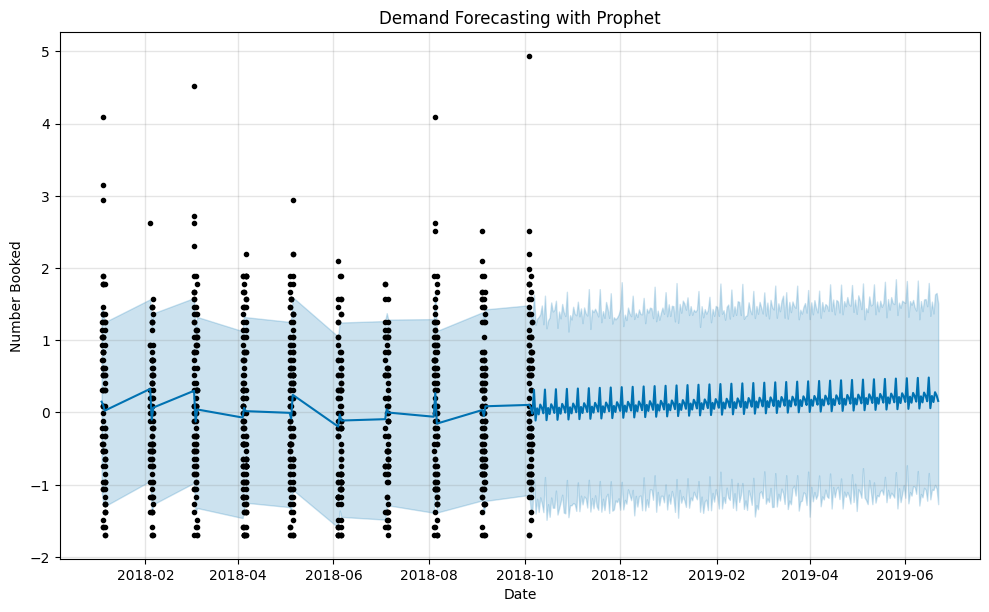

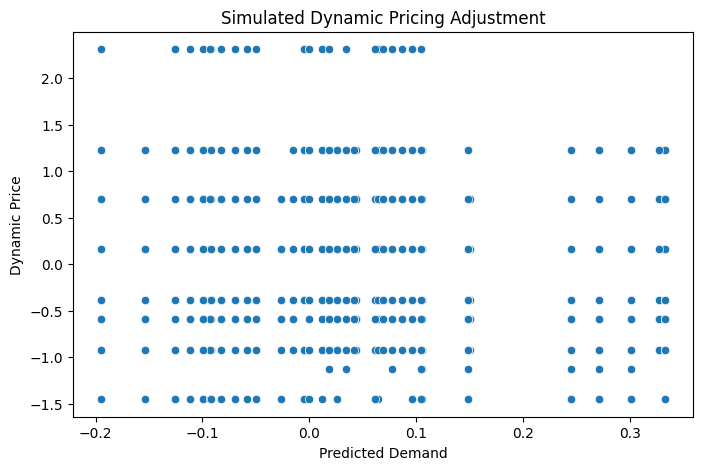

In [7]:
import pandas as pd
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Data
file_path = '/content/drive/My Drive/CultFit_Project/Cleaned_Classes_April_June_final.csv'
df = pd.read_csv(file_path)

# Convert Date column and remove rows with NaT
df['Date'] = pd.to_datetime(df['BookingEndDateTime'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# Step 2: Train Demand Forecasting Model (Prophet)
df_forecast = df[['Date', 'Number_Booked']].rename(columns={'Date': 'ds', 'Number_Booked': 'y'})
df_forecast = df_forecast.sort_values(by='ds').reset_index(drop=True)

# Check for non-numeric values in 'y' column
non_numeric_y = df_forecast[pd.to_numeric(df_forecast['y'], errors='coerce').isna()]
if not non_numeric_y.empty:
    print("Found non-numeric values in 'y' column:")
    display(non_numeric_y)
    # Exit or handle the non-numeric values as appropriate
    # For now, we will stop here to let you inspect the data
    raise ValueError("Non-numeric values found in 'y' column.")


# Train-Test Split
train_size = int(len(df_forecast) * 0.8)
train_df = df_forecast.iloc[:train_size]
test_df = df_forecast.iloc[train_size:]

model = Prophet(daily_seasonality=True)
model.fit(train_df)

# Forecast next N days (simulate future demand)
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

# Evaluation
forecasted_values = forecast['yhat'][-len(test_df):].values
actual_values = test_df['y'].values

mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

# Plot forecast
fig1 = model.plot(forecast)
plt.title('Demand Forecasting with Prophet')
plt.xlabel('Date')
plt.ylabel('Number Booked')
plt.show()

# Step 3: Define Pricing Rules Based on Demand Forecast and Price Elasticity Insights
def dynamic_pricing(row, predicted_demand):
    base_price = row['Price_INR']
    capacity = row['MaxBookees']
    demand_factor = row['Number_Booked'] / (capacity + 1e-5)

    # Pricing Rule Logic:
    if predicted_demand > 1.5:  # High forecasted demand
        price = base_price * 1.25  # Increase by 25%
    elif predicted_demand < 0.5:  # Low forecasted demand
        price = base_price * 0.85  # Decrease by 15%
    else:
        price = base_price  # No change

    return round(price, 2)

# Step 4: Simulate Pricing Adjustments
# Merge forecast back into main DataFrame by Date
forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Predicted_Demand'})
df = pd.merge(df, forecast_df, how='left', left_on='Date', right_on='Date')

# Apply dynamic pricing rule
df['DynamicPrice'] = df.apply(lambda row: dynamic_pricing(row, row['Predicted_Demand']), axis=1)

# Step 5: Visualize Simulated Dynamic Price Adjustments
plt.figure(figsize=(8,5))
sns.scatterplot(x='Predicted_Demand', y='DynamicPrice', data=df)
plt.xlabel('Predicted Demand')
plt.ylabel('Dynamic Price')
plt.title('Simulated Dynamic Pricing Adjustment')
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
